# CMIP6 Post-CMOR Plotting Program  
(plotcheck.py)

Goal: After CMORizing E3 output, visualize all variables processed (where possible).
- Ensure that the data are of expected magnitude and distribution and that they are time-varying.
- Compare to available E2.X runs of similar configuration.
- Output key statistics that may give a snapshot overview of run.
- Make simple & efficient. Add complexity later if need be.

In [3]:
import xarray as xr
import pandas as pd
import numpy as np
import glob
import os
import time
import cartopy.crs as ccrs
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages as pdf
from cmor_plot.cmor_plot.cptools import Tools as cpt

In [ ]:
start = time.time()

# Get work directory
#wd = os.getcwd()
wd = "/gpfsm/dnb05/projects/p54/users/melling/process/cmor_plotcheck/"
# Input the name of the E3 run directory up to the variant label
runE2 = "/css/cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/historical/r1i1p1f1/"
runE3 = "/discover/nobackup/projects/cmip6/e3staging/CMIP6/CMIP/NASA-GISS/GISS-E3-G/historical/r1i1p101f1/"
outdir = wd
figname = 'mkE3trn698c'
allvarsE2 = runE2 + "*/*/*/*"
allvarsE3 = runE3 + "*/*/*/*"

pp = pdf(wd + figname + '.pdf')
os.chdir(outdir)

###################################################################################################################################################

# Loop through the E3 directory 

for direc3 in glob.glob(allvarsE3):
    os.chdir(outdir)

    # Call 'get_sample' for E3, save filename and open dataset
    fileE3 = cpt.get_sample(direc3, outdir)
    #fileE3 = sample
    if ('/fx/' in fileE3) | ('/fy/' in fileE3) | ('/Ofx/' in fileE3) | ('/Ofy/' in fileE3):
        print("(O)f[x/y] detected. Skipping...")
    elif ('gyre' in fileE3) | ('gyre' in fileE3):
        print("Temporarily skipping. Will create logic for plot dims later...")
    else: 
        # Open the sample E3 file 
        dsE3 = xr.open_dataset(fileE3)

        # Get relevant varname & frequency
        freq = direc3.split("/")[-4]
        varname = direc3.split("/")[-3]
        gride3 = direc3.split("/")[-2]
        modelv2 = runE2.split('CMIP6')[1].split('/')[3]
        # modelv2 = direc2.split("/")[-7]  # A problem when e2 directory structure not the same
        modelv3 = direc3.split("/")[-7]

        # Try to find the same var/freq in E2
        # start here-- basically try to get the same file using the freq and varname defined earlier. if exception, plot no data
        e3version = direc3.split("/")[-1]
        e2path_short = runE2 + direc3.split(e3version)[0].split(runE3)[1]
        e2path_full = e2path_short + "*"
        direc2 = glob.glob(e2path_full)
        if len(direc2) > 0:
            direc2 = direc2[0]
            os.chdir(direc2) # if this fails, there was no path found (aka no matching data)
            fileE2 = cpt.get_sample(direc2, outdir)
            #fileE2 = sample

            # creat e2 dataset
            dsE2 = xr.open_dataset(fileE2)

            # Verify that E2 variable exists, and carry on
            varexist = 1
        else:
            # Check if there is a native grid E2 match to E3 regridded
            if gride3 == "gr":
                e2path_full_native = e2path_full.replace("/gr/", "/gn/")
                direc2 = glob.glob(e2path_full_native)
                if len(direc2) > 0:
                    direc2 = direc2[0]
                    os.chdir(direc2) # if this fails, there was no path found (aka no matching data)
                    fileE2 = cpt.get_sample(direc2, outdir)
                    #fileE2 = sample

                    # creat e2 dataset
                    dsE2 = xr.open_dataset(fileE2)

                    # Verify that E2 variable exists, and carry on
                    varexist = 1
                else: 
                    varexist = 0
                    
            else:   
                print("No E2 match found for " + fileE3.split('/')[-1] + ", skipping...")
                dsE2 = None
                varexist = 0

        # Check for num dimensions
        dsE3 = cpt.check_dim(dsE3, varname)
        if varexist == 1:
            dsE2 = cpt.check_dim(dsE2, varname)
            arr_arr = cpt.getstats(dsE3, dsE2, varexist, varname)
        elif varexist == 0:
            arr_arr = cpt.getstats(dsE3, None, varexist, varname)
            
        arr_arr_str = ["maxval", "minval", "timemean", "vmax", "vmin"]

        # Loop through array and set variables
        for arr, n in zip(arr_arr_str, np.arange(0,len(arr_arr), 1)):
            locals()[arr] = arr_arr[n]

        # Title
        years = fileE3.split('_')[-1].split('.')[0]
        m3title = "mean " + varname + " " + freq + "\n" + " [" + direc3.split("/")[-7] + " " + direc3.split("/")[-6] + " " + direc3.split("/")[-5] + " " + direc3.split("/")[-2] + " " + direc3.split("/")[-1] + " " + "(" + years + ")" + "] "
        if varexist == 1:
            m2title = "mean " + varname + " " + freq + "\n" + " [" + direc2.split("/")[-7] + " " + direc2.split("/")[-6] + " " + direc2.split("/")[-5] + " " + direc2.split("/")[-2] + " " + direc2.split("/")[-1] + " " + "(" + years + ")" + "] "

        # Plot vals
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (25, 13))
        plt.subplots_adjust(hspace = 0.5)
        central_lon = 0
        ax = plt.axes(projection=ccrs.Robinson())

        # Get cbar labels
        try:
            labele3 = dsE3[varname].attrs["units"]
        except:
            labele3 = varname
        try:
            labele2 = dsE2[varname].attrs["units"]
        except:
            labele2 = varname

        # E3
        # Temporarily skip the non lat,lon,time vars
        vardims3 = timemean[0].dims
        if ('lat' in vardims3) & ('lon' in vardims3):
            ax1 = plt.subplot(2, 3, 1, projection=ccrs.Robinson(central_lon))
            ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--')
            timemean[0].plot(transform=ccrs.PlateCarree(), cbar_kwargs={'orientation':'horizontal','pad': 0.06, 'label':labele3}, 
                            vmax = maxval[0], vmin = minval[0])
            plt.title(m3title)
            ax1.coastlines();
            ax1.set_rasterized(True)
        else:
            ax1 = plt.subplot(2, 3, 1)#projection=ccrs.Robinson(central_lon))
            ax1.text(0.25, 0.5, 'fix 2d plotting code', fontsize = 40)
            plt.xticks([])
            plt.yticks([])

        # E2
        if varexist == 1:
            vardims2 = timemean[1].dims
            if ('lat' in vardims2) & ('lon' in vardims2):
                ax2 = plt.subplot(2, 3, 2, projection=ccrs.Robinson(central_lon))
                ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--')
                timemean[1].plot(transform=ccrs.PlateCarree(), cbar_kwargs={'orientation':'horizontal','pad': 0.06, 'label':labele3}, 
                                vmax = maxval[1], vmin = minval[1])
                plt.title(m2title)
                ax2.coastlines();
                ax2.set_rasterized(True)
            else:
                ax2 = plt.subplot(2, 3, 2)#projection=ccrs.Robinson(central_lon))
                ax2.text(0.25, 0.5, 'fix 2d plotting code', fontsize = 40)
                plt.xticks([])
                plt.yticks([])
        else:
            ax2 = plt.subplot(2, 3, 2)#projection=ccrs.Robinson(central_lon))
            ax2.text(0.25, 0.5, 'NO DATA', fontsize = 40)
            plt.xticks([])
            plt.yticks([])

        # Key statistics
        df = pd.DataFrame()
        df[" "] = ["min", "max"]

        df[modelv3] = [np.round(minval[0], 2), np.round(maxval[0], 2)]
        try:
            df[modelv2] = [np.round(minval[1], 2), np.round(maxval[1], 2)]
        except: # If no  E2 data, rounding will not work. Just append "NA" string
            df[modelv2] = [minval[1], maxval[1]]

        ax3 = plt.subplot(2, 3, 3)
        ax3.table(cellText=df.values, colLabels=df.keys(), loc='center')
        plt.xticks([])
        plt.yticks([])

        # Save figure
        pp.savefig(dpi=300)
        
        # del datasets variables to save RAM (probably unecessary)
        try:
            del dsE3
            del dsE2
        except:
            try:
                del dsE3
            except:
                None
pp.close()


end = time.time()
totalt = end - start
print("Total runtime: " + str(totalt) + " seconds")

/gpfsm/dnb53/tdirs/batch/slurm.13713503.melling/ipykernel_183111/2276263167.py:105: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (25, 13))


(O)f[x/y] detected. Skipping...
(O)f[x/y] detected. Skipping...
(O)f[x/y] detected. Skipping...


### To do next:
not super important but could count variables iterated for time reference

In [16]:
test = xr.open_dataset('/css/cmip6/CMIP6/CMIP/NASA-GISS/GISS-E3-G/historical/r1i1p1f1/Omon/htovovrt/gn/v20220727/htovovrt_Omon_GISS-E3-G_historical_r1i1p1f1_gn_195001-199912.nc')

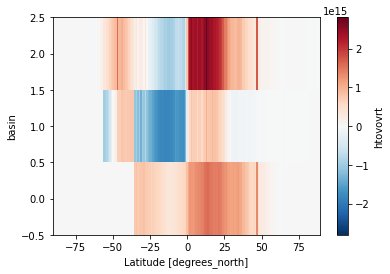

In [33]:
test.htovovrt.mean('time').plot()

In [36]:
timemean[0].dims

('basin', 'lat')